# Deep Image Prior for Image Anonymization

@Author: Francesco Picetti - francesco.picetti@polimi.it

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import numpy as np
from models.resnet import ResNet
from models.unet2 import UNet
from models.skip import skip
import torch
import torch.optim
from utils.common_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

from scipy.io import loadmat
from utils import utils as u
u.set_gpu(-1)

GPU selected: 0 - GeForce GTX 1080 Ti


### Load image and reference PNRU

In [2]:
img = mpimg.imread('/nas/home/smandelli/ispg-greeneyes-data/icip2017_ImageAnonymizer/online_code/single_code/dataset/Nikon_D70s_1/Nikon_D70s_1_22903.png')
k = loadmat('/nas/home/smandelli/ispg-greeneyes-data/icip2017_ImageAnonymizer/online_code/single_code/PRNUs/Nikon_D70s_1/prnu_cropped512.mat')['prnu']
img_benchmark = mpimg.imread('/nas/home/smandelli/ispg-greeneyes-data/icip2017_ImageAnonymizer/online_code/single_code/anonymized_img/Nikon_D70s_1/Nikon_D70s_1_22903.png')

In [3]:
print("Sara aveva ottenuto un PSNR di %.2f dB" % u.psnr(u.float2png(img), u.float2png(img_benchmark)))

Sara aveva ottenuto un PSNR di 43.23 dB


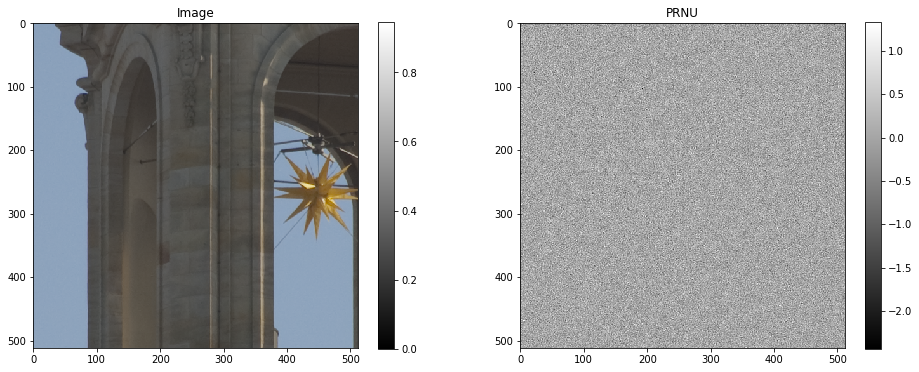

In [4]:
plt.figure(figsize=(16,6))
plt.subplot(121), plt.imshow(img, cmap='gray'), plt.colorbar(), plt.title('Image')
plt.subplot(122), plt.imshow(k, cmap='gray'), plt.colorbar(), plt.title('PRNU')
plt.show()

In [5]:
img_var = u.numpy2torch(np.swapaxes(img, 2, 0)[np.newaxis])
k_var = u.numpy2torch(k[np.newaxis,np.newaxis])

In [6]:
# Same params and net as in super-resolution and denoising
input_depth = 512
LR = 0.001 
num_iter = 6001
param_noise = False
show_every = 50
reg_noise_std = 0.03

net = UNet(num_input_channels=input_depth,
           num_output_channels=3, 
           filters=[16, 32, 64, 128, 256],
           more_layers=1, 
           concat_x=False,
           upsample_mode='nearest', 
           activation='ReLU',
           pad='zero',
           norm_layer=torch.nn.InstanceNorm2d,
           need_sigmoid=True,
           need_bias=True
          )
net = net.type(dtype)
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

Number of params: 5772259


In [9]:
l2dist = torch.nn.MSELoss().type(dtype)
iiter = 0

def closure():
    
    global iiter
    global out_np
    global out
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
            
    out = net(net_input)    
    total_loss  = l2dist(u.add_prnu(out, k_var), img_var)
    total_loss.backward()
    
    out_np = np.swapaxes(u.torch2numpy(out).squeeze(),0,-1)
    
    # these metrics are slowing down the script as they are computed on CPU
    print ('Iteration %5d, Loss = %.2e, PSNR = %.2f dB, SSIM = %.4f, NCC = %.6f'
           % (iiter, total_loss.item(),
              u.psnr(u.float2png(out_np), u.float2png(img)),
              u.compute_ssim(img, out_np),
              u.ncc(k, u.prnu.extract_single(u.float2png(out_np)))),
           '\r', end='')
    
    if iiter % show_every == 0:
        plt.figure(figsize=(16, 6))
        plt.subplot(121), plt.imshow(out_np), plt.title('Anonymized')
        plt.subplot(122), plt.imshow(img), plt.title('Original')
        plt.show()
        
    iiter += 1

    return total_loss

Starting optimization with ADAM


/nas/home/fpicetti/miniconda3/envs/deep-image-prior/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


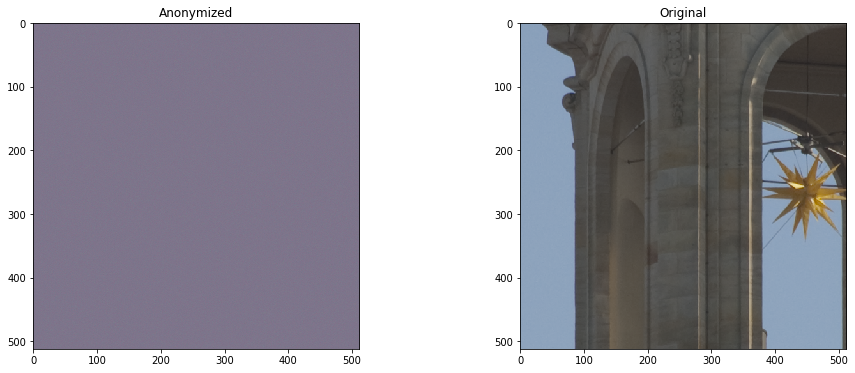

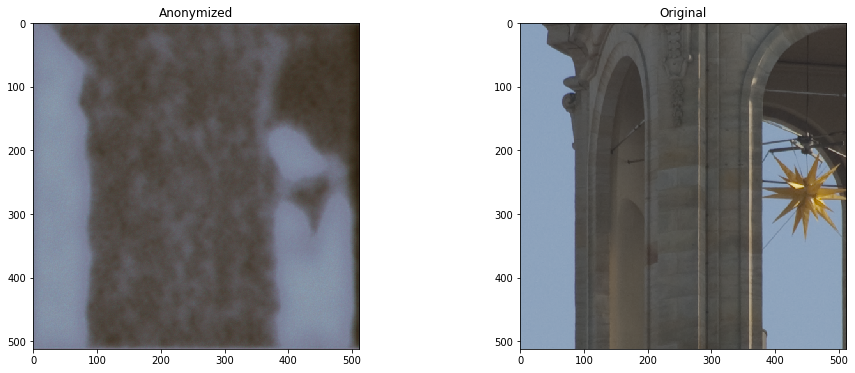

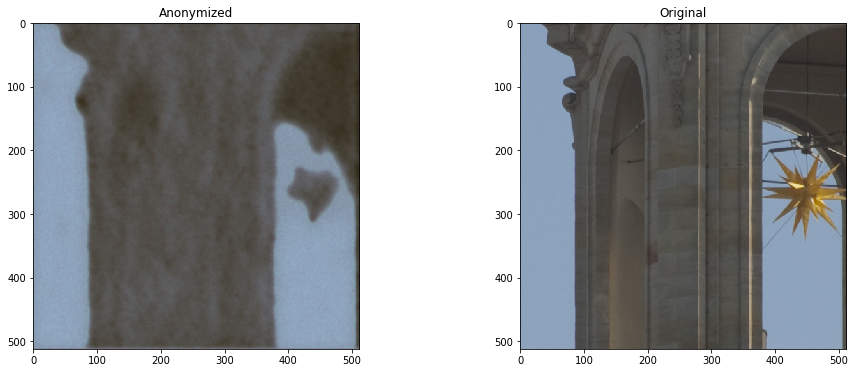

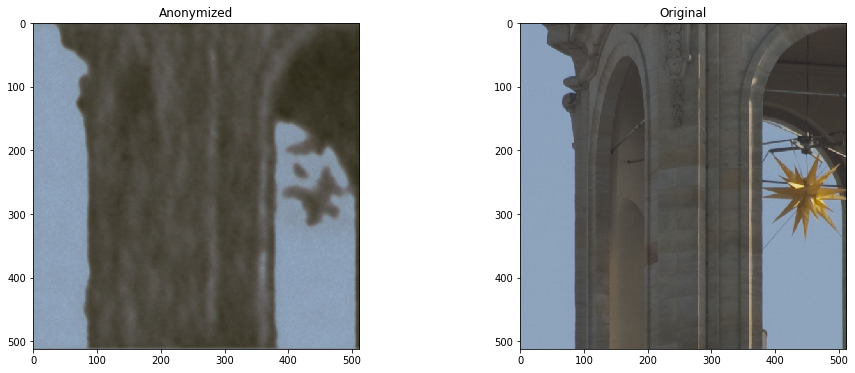

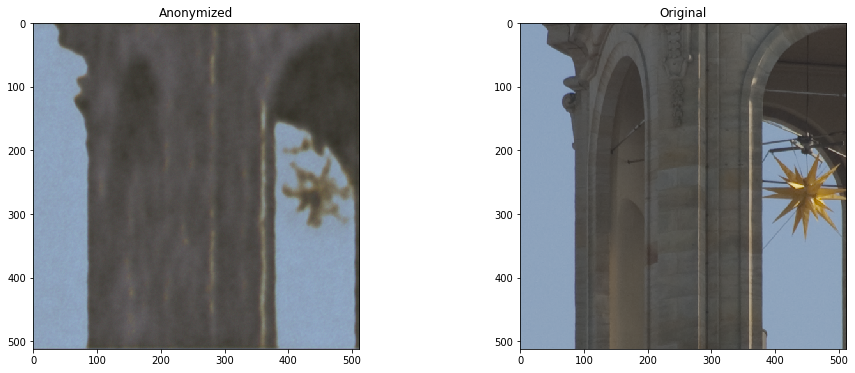

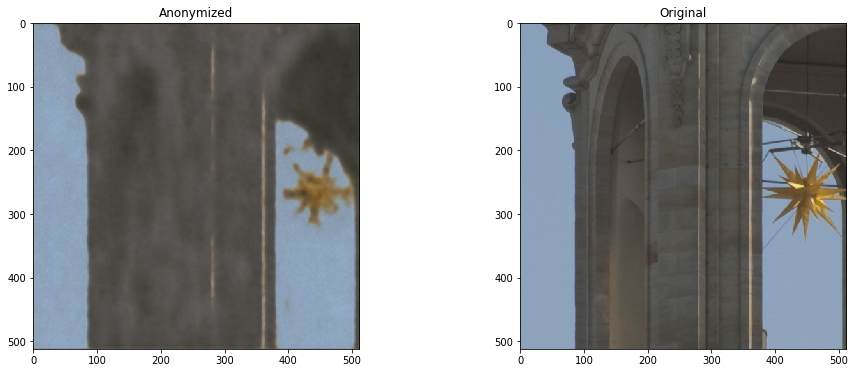

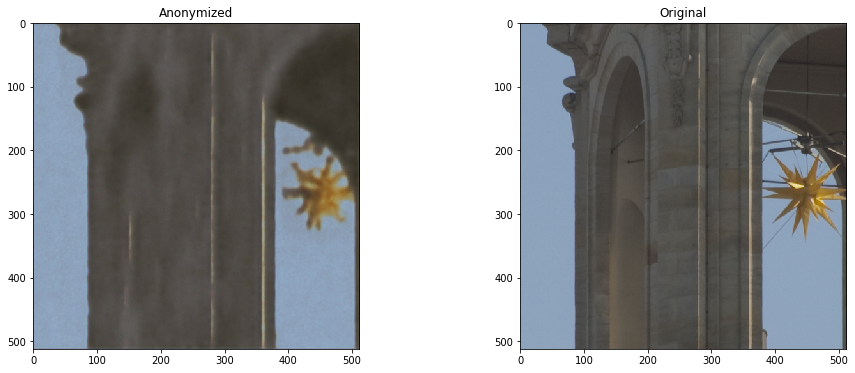

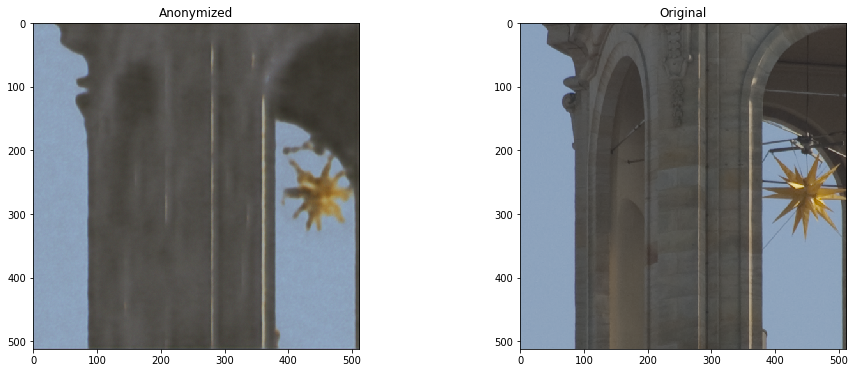

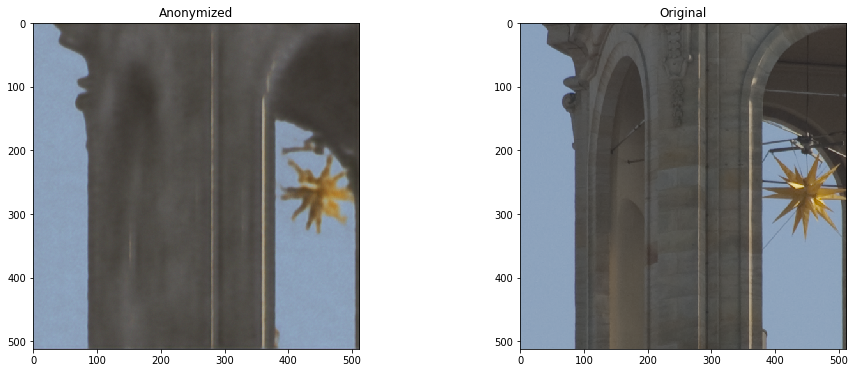

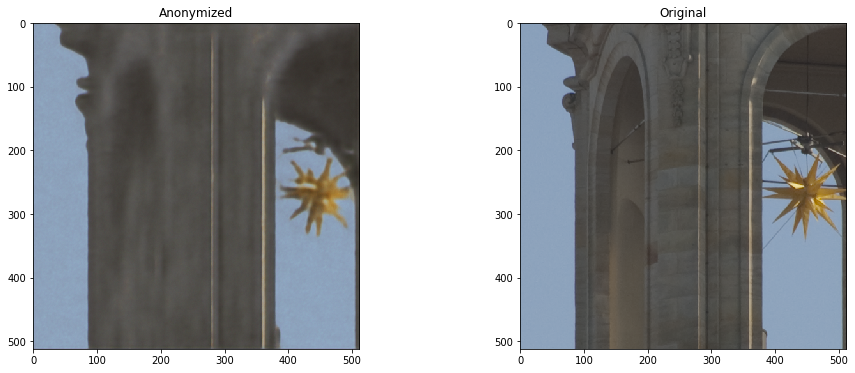

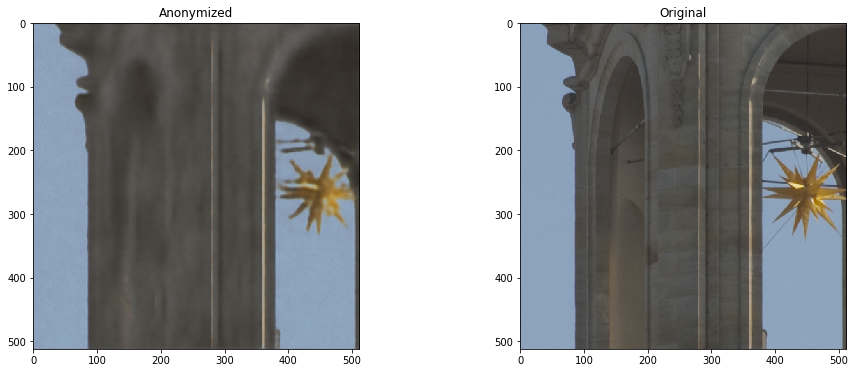

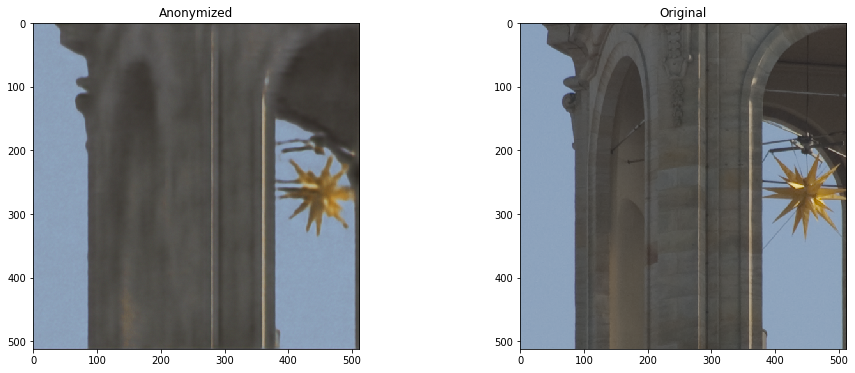

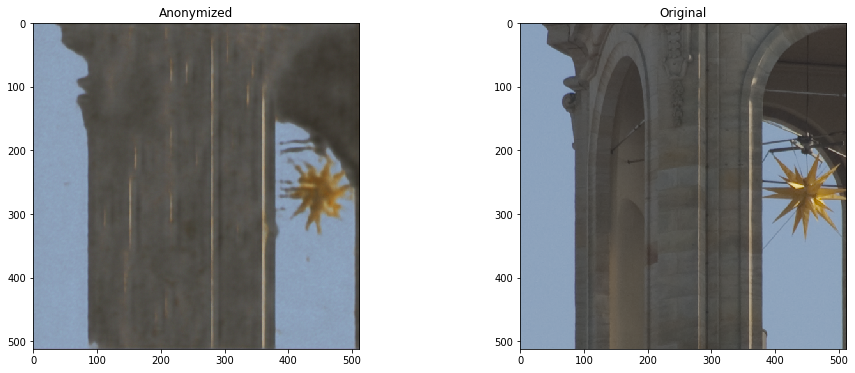

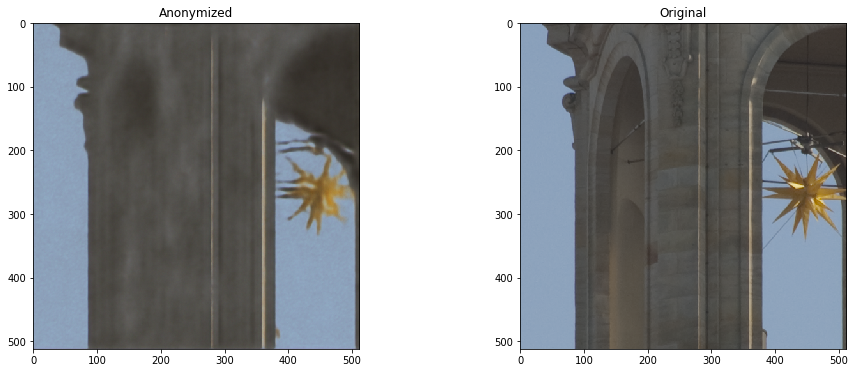

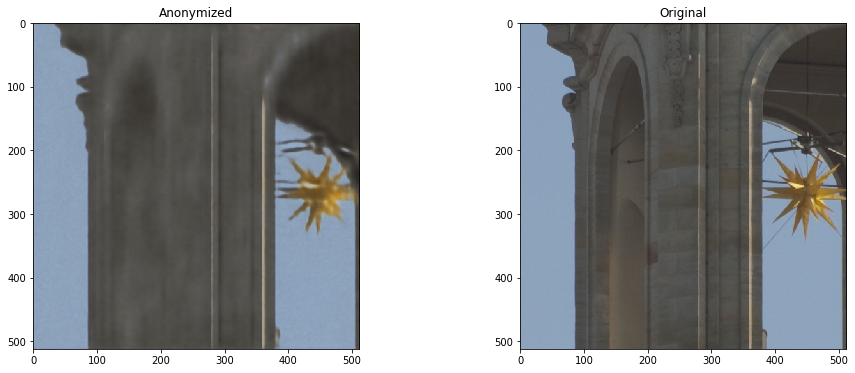

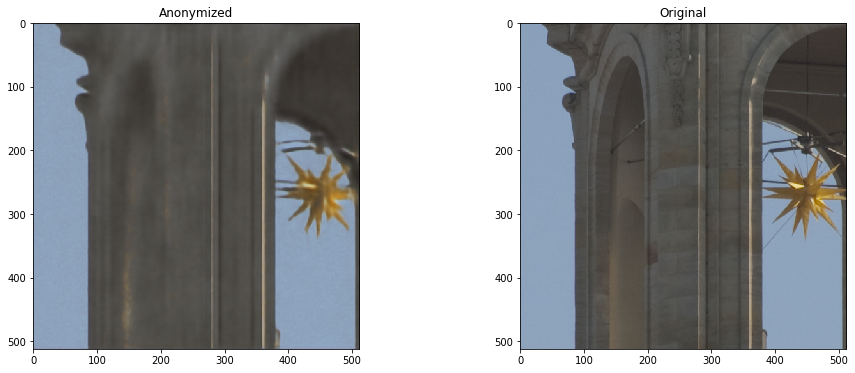

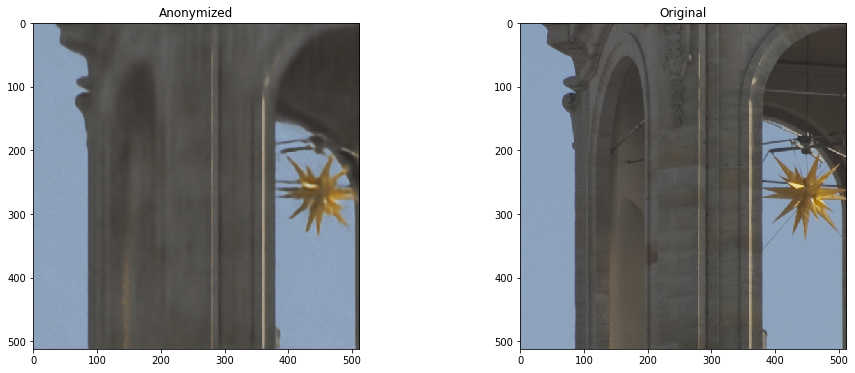

In [ ]:
net_input = get_noise(input_depth, 'noise', img.shape).type(dtype)
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params('net', net, net_input)
optimize('adam', p, closure, LR, num_iter)